In [1]:
import pandas as pd
from collections import OrderedDict
import pytz
from zipline.api import order, record, symbol, set_benchmark, order_target_percent, get_open_orders
#from zipline.utils.exchange_calendar_twentyfourhr import TwentyFourHR
import zipline
import matplotlib.pyplot as plt
from datetime import datetime


def initialize(context):
    set_benchmark(symbol("BTC"))


def handle_data(context, data):

    slowma = data.history(symbol("BTC"), fields='price', bar_count=50, frequency='1m').mean()
    fastma = data.history(symbol("BTC"), fields='price', bar_count=10, frequency='1m').mean()
    now = data.current(symbol("BTC"), 'price')
    open_orders = get_open_orders()
    #print(open_orders)
    #print("now",end=":")
    #print(now)
    #print("slowma",end=":")
    #print(slowma)
    if now < slowma:
        if symbol("BTC") not in get_open_orders():
            order_target_percent(symbol("BTC"), -1)

    if now > slowma:
        if symbol("BTC") not in get_open_orders():
            order_target_percent(symbol("BTC"), 0.02)

    record(BTC=data.current(symbol('BTC'), fields='price'))


data = OrderedDict()
data['BTC'] = pd.read_csv("BTC-USD.csv")

data['BTC']['date'] = pd.to_datetime(data['BTC']['time'], unit='s', utc=True)
data['BTC'].set_index('date', inplace=True)
data['BTC'].drop('time', axis=1, inplace=True)
data['BTC'] = data['BTC'].resample("1min").mean()
data['BTC'].fillna(method="ffill", inplace=True)
data['BTC'] = data['BTC'][["low","high","open","close","volume"]]
print(data['BTC'].head())

panel = pd.Panel(data)
panel.minor_axis = ["low","high","open","close","volume"]
panel.major_axis = panel.major_axis
#panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

from trading_calendars import get_calendar

always_calendar = get_calendar('24/7')

perf = zipline.run_algorithm(start=datetime(2018, 3, 23, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2018, 3, 26, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      trading_calendar=always_calendar,
                      capital_base=10000,
                      handle_data=handle_data,
                      data_frequency ='minute',
                      data=panel)

ModuleNotFoundError: No module named 'zipline'

In [142]:
perf.head()

,BTC,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-03-23 23:59:00+00:00,8927.099609,NaN,0.0,NaN,0.024327,NaN,NaN,0.0,10000,0.0,...,0.0,0.0,0,None,10000,0.0,0.0,1,[],0.0
2018-03-24 23:59:00+00:00,8531.339844,0.0,0.0,0.0,-0.021084,0.770698,0.0,0.0,10000,0.0,...,0.0,0.0,0,None,10000,0.0,0.0,2,[],0.0
2018-03-25 23:59:00+00:00,8452.959961,0.0,0.0,0.0,-0.030078,0.545017,0.0,0.0,10000,0.0,...,0.0,0.0,0,None,10000,0.0,0.0,3,[],0.0
2018-03-26 23:59:00+00:00,8145.000000,0.0,0.0,0.0,-0.065414,0.492895,0.0,0.0,10000,0.0,...,0.0,0.0,0,None,10000,0.0,0.0,4,[],0.0


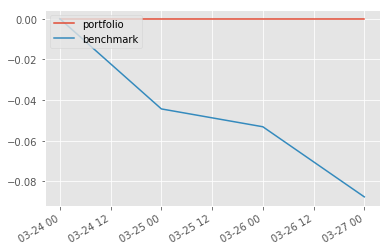

In [143]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.BTC.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='benchmark')
plt.legend(loc=2)

plt.show()